In [1]:
import numpy as np
import qutip as qt
import time
# plotting setup
import matplotlib.pyplot as plt
plt.style.use('SciencePlots-APS.mplstyle')

In [2]:
def sigmaz_k(k, N):
    '''
    Calculate \sigma^{z}_{i}
    '''
    if k < 0 or k >= N:
        raise ValueError(f"Position k = {k} is out of range for N = {N}")
    ops = [qt.qeye(2) if i != k else qt.sigmaz() for i in range(N)]
    return qt.tensor(ops)

def sigmax_k(k, N):
    '''
    Calculate \sigma^{x}_{i}
    '''
    if k < 0 or k >= N:
        raise ValueError(f"Position k = {k} is out of range for N = {N}")
    ops = [qt.qeye(2) if i != k else qt.sigmax() for i in range(N)]
    return qt.tensor(ops)

def propagate(valsHam, vecsHam, t):
    '''
    Determine unitary evolution operator exp(-i.H.t)
    using matrix eigendecomposition exp(A) = P.exp(D).P^-1    
    '''
    # Calculate N based on the number of eigenvalues
    N = int(np.log2(len(valsHam))) 
    # Set up the dimensions for a quantum object
    dimension = [[2]*N, [2]*N]
    # Convert the list of eigenvectors to a matrix
    P = qt.Qobj(np.hstack(vecsHam), dims=dimension)
    # Create diagonal matrix of exp of eigenvalues
    ExpDiag = qt.Qobj(np.diag(np.exp(-1.j * valsHam * t)), dims=dimension)
    # Construct the unitary evolution operator
    U = P * ExpDiag * P.dag()   
    # Return the unitary evolution operator
    return U

# def propagate(H, t):
#     '''
#     Determine unitary evolution operator exp(-i.H.t)
#     using matrix eigendecomposition exp(A) = P.exp(D).P^-1
#     '''
#     # calculate eigenvalues and eigenvectors
#     vals, vecs = H.eigenstates()
#     # convert the list of eigenvectors to a matrix
#     P = qt.Qobj(np.hstack(vecs), dims=H.dims)
#     # create diagonal matrix of exp of eigenvalues
#     ExpDiag = qt.Qobj(np.diag(np.exp(-1.j * vals * t)), dims=H.dims)
#     # construct the unitary evolution operator
#     U = P * ExpDiag * P.dag()   
#     return U

Quantum Ising model:

$${\cal H}=-J\sum_{i=1}^{N-1}\sigma_{i}^{z}\sigma_{i+1}^{z}-h\sum_{i=1}^{N}\sigma_{i}^{z}-g\sum_{i=1}^{N}\sigma_{i}^{x}$$

In [3]:
def Ham_Ising(N, J, h, g):
    '''
    Quantum Ising model 1D
    '''
    # Ising 
    ising_term = -J * sum([(sigmaz_k(i, N) * sigmaz_k(i + 1, N)) for i in range(N - 1)])
    # Longitudinal
    longitudinal_term = -g * sum([sigmax_k(i, N) for i in range(N)])   
    # Tranverse
    transverse_term = -h * sum([sigmaz_k(i, N) for i in range(N)])    
    # Total Hamiltonian
    Ham = ising_term + transverse_term + longitudinal_term
    return Ham

Initial state, we consider a Gibbs state at finite temperature $T$:

$$
\rho_0 = \frac{1}{\mathcal{Z}}\exp{\left(-\frac{H}{T}\right)}
$$

with $T/J=1$, $\mathcal{Z}=\mathrm{Tr}[(\exp{(-H/T)}]$, and $k_{B}=1$

In [4]:
def rho_T(valsHam, vecsHam, T):
    '''
    Compute the Gibbs state rho_T using matrix eigendecomposition.
    '''
    N = int(np.log2(len(valsHam))) 
    dimension = [[2]*N, [2]*N]
    # create matrix diagonalization
    ExpDiag = qt.Qobj(np.diag(np.exp(-valsHam / T)), dims=dimension)
    # convert the list of eigenvectors to matrix
    P = qt.Qobj(np.hstack(vecsHam), dims=dimension)
    rho_ = P * ExpDiag * P.dag()
    Z = rho_.tr()
    return rho_ / Z

# def rho_T(Ham, T):
#     '''
#     Compute the Gibbs state rho_T using matrix eigendecomposition.
#     '''
#     # calculate eigenvalues and eigenvectors
#     vals, vecs = Ham.eigenstates()
#     # create matrix diagonalization
#     ExpDiag = qt.Qobj(np.diag(np.exp(-vals / T)), dims=Ham.dims )
#     # convert the list of eigenvectors to matrix
#     P = qt.Qobj(np.hstack(vecs), dims=Ham.dims)
#     rho_ = P * ExpDiag * P.dag()
#     Z = rho_.tr()
#     return rho_ / Z

The OTOC defined as follow

$$
F(t):=\mathrm{Tr}[W^{\dagger}(t)V^{\dagger}W(t)V\rho]
$$

In [5]:
def F_wo_decoherence(valsHam, vecsHam, W, V, rho0, t):
    U_t = propagate(valsHam, vecsHam, t)
    W_t = U_t.dag() * W * U_t
    correlator = (W_t.dag() * V.dag() * W_t * V * rho0).tr()
    return np.real(correlator)

Define $W$ and $V$ as follows:

$$
W = \sigma^{z}_{1} \\
V = \sigma^{z}_{N}
$$

In [6]:
# Parameters
N = 5              # number of qubits
J = 1.0
h = 0.5
#h = 0.5 * J
g = 1.05 * J
T = 1.0 / J
T_2_star = 1.2
gamma = 1/(2 * T_2_star)
#T_2_star = 0.000130

# Define W and V
W = sigmaz_k(0, N)
V = sigmaz_k(N-1, N)

tlist = np.linspace(0., 10., 100)

# calculate eigenvalues and eigenvectors of Hamiltonian
valsHam_Ising, vecsHam_Ising = Ham_Ising(N, J, h, g).eigenstates()

## OTOCs without decoherence

In [7]:
rho0 = rho_T(valsHam_Ising, vecsHam_Ising, T)

OTOCsList = np.array([F_wo_decoherence(valsHam_Ising, vecsHam_Ising, W, V, rho0, t) for t in tlist])

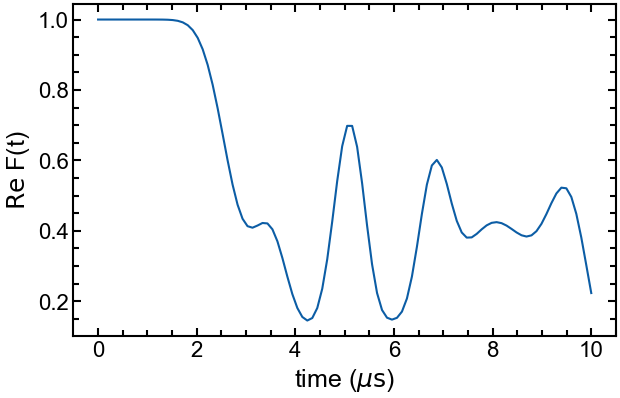

In [8]:
fig = plt.figure()

plt.plot(tlist, OTOCsList)
# X-axis
plt.xlabel('time ($\mu \mathrm{s}$)')
plt.ylabel('$\mathrm{Re}$ F(t)')

plt.show()

## OTOCs with decoherence

In [9]:
def lindblad_ops(N, T_2_star):
    '''
    introduce Lindbland operators into the system
    L_{i} = \sqrt{\gamma_{i}}\sigma^{z}_{i}
    '''
    gamma = 1./(2.*T_2_star)
    c_ops = []
    for i in range(N):
        Li = sigmaz_k(i, N)
        c_ops.append(np.sqrt(gamma) *Li)
    return c_ops

# def F_w_decoherence(Ham, W, V, rho0, t, c_ops):
#     '''
#     OTOCs with the decoherence
#     '''
#     result = qt.mesolve(Ham, rho0, [t], c_ops)
#     rho_t = result.states[0]
#     U_t = propagate(Ham, t)
#     W_t = U_t.dag() * W * U_t
#     correlator = (W_t.dag() * V.dag() * W_t * V * rho_t).tr()
#     return np.real(correlator)

def F_w_decoherence(valsHam, vecsHam, W, V, rho0, tlist, c_ops):
    '''
    OTOCs with the decoherence for a list of times
    '''

    # Reconstruct the Hamiltonian from its eigenvalues and eigenvectors
    N = int(np.log2(len(valsHam)))
    dimension = [[2] * N, [2] * N]
    P = qt.Qobj(np.hstack(vecsHam), dims=dimension)
    Ham = P * qt.Qobj(np.diag(valsHam), dims=dimension) * P.dag()
    
    # Evolve the density matrix under the influence of Hamiltonian and decoherence
    opts = qt.Options(nsteps=10000)  # default is 1000
    results = qt.mesolve(Ham, rho0, tlist, c_ops, options=opts)    
    correlators = []
    for t, rho_t in zip(tlist, results.states):
        
        # Find the evolved operator W(t) = U†(t) W U(t)
        U_t = propagate(valsHam, vecsHam, t)
        W_t = U_t.dag() * W * U_t

        # Calculate the correlator
        correlator = (W_t.dag() * V.dag() * W_t * V * rho_t).tr()
        correlators.append(np.real(correlator))
    
    return correlators

# def F_w_decoherence(Ham, W, V, rho0, tlist, c_ops):
#     '''
#     OTOCs with the decoherence for a list of time points
#     '''
# 
#     # Evolve the density matrix under the influence of Hamiltonian and decoherence
#     opts = qt.Options(nsteps=10000)  # default is 1000, so you might want to increase
#     results = qt.mesolve(Ham, rho0, tlist, c_ops, options=opts)    
#     correlators = []
#     for t, rho_t in zip(tlist, results.states):
#         
#         # Find the evolved operator W(t) = U†(t) W U(t)
#         U_t = propagate(Ham, t)
#         W_t = U_t.dag() * W * U_t
# 
#         # Calculate the correlator
#         correlator = (W_t.dag() * V.dag() * W_t * V * rho_t).tr()
#         correlators.append(np.real(correlator))
#     
#     return correlators

In [10]:
start = time.time()
c_ops = lindblad_ops(N, T_2_star)

OTOCsListDecoherence = F_w_decoherence(valsHam_Ising, vecsHam_Ising, W, V, rho0, tlist, c_ops)
end = time.time()
print('Time consuming = {:12.4f} seconds'.format(end - start))

Time consuming =       0.3145 seconds


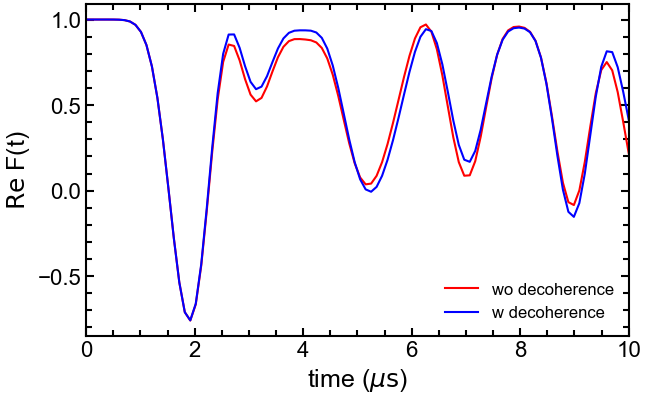

In [11]:
fig = plt.figure()

plt.plot(tlist, OTOCsList, 'r-', label='wo decoherence')
plt.plot(tlist, OTOCsListDecoherence, 'b-', label='w decoherence')
# X-axis
plt.xlabel('time ($\mu \mathrm{s}$)')
plt.xlim(tlist[0], tlist[-1])
#plt.ylim(0.0, 1.0)
plt.ylabel('$\mathrm{Re}$ F(t)')

plt.legend(loc='best')

plt.show()

## Stochastic phase jump

$\rho\mapsto d t\sum_{i}\gamma_{i}L_{i}U(t)\rho U(t)^{\dagger}L_{i}^{\dagger}+L_{0}U(t)\rho U(t)^{\dagger}L_{0}^{\dagger}.$

where $L_{0}=\sqrt{\mathbb{1}-d t{\sum_{i}}\gamma_{i}{L}_{i}^{\dagger}{L}_{i}}$, $U(t) = \exp{(- i H t)}$, $L_{i}=\sigma^{z}_{i}$ and $\gamma_{i} = \gamma= 1/(2 T_{2})$

## Extended Kirkwood-Dirac quasiprobability distribution 

In [12]:
#################
# VERSION 1
#################
#def get_projectors(op):
#    '''
#    Projectors for an operator
#    '''
#    vals, vecs = op.eigenstates()
#    projectors = [(val, vec * vec.dag()) for val, vec in zip(vals, vecs)]
#    return projectors
#
#def quasiprobability_distribution(rho, W, V, valsHam, vecsHam, t):
#    '''
#    Calculate quasiprobability distribution.
#    '''
#    U_t = propagate(valsHam, vecsHam, t)
#    W_t = U_t * W * U_t.dag()
#
#    projectors_W = get_projectors(W_t)
#    projectors_V = get_projectors(V)
#
#    len_W, len_V = len(projectors_W), len(projectors_V)
#    P_tilde = np.zeros((len_W, len_V, len_W, len_V), dtype=np.complex128)
#
#    for i, (_, Pi_w3) in enumerate(projectors_W):
#        for j, (_, Pi_v2) in enumerate(projectors_V):
#            for k, (_, Pi_w2) in enumerate(projectors_W):
#                for l, (_, Pi_v1) in enumerate(projectors_V):
#                    P_tilde[i, j, k, l] = (Pi_w3 * Pi_v2 * Pi_w2 * Pi_v1 * rho).tr()
#
#    return P_tilde
#
#def OTOC_via_QD(P_tilde, projectors_W, projectors_V):
#    '''
#    Calculate Out-of-Time-Ordered Correlator (OTOC)
#    via quasiprobability distribution
#    '''
#    otoc = 0
#    for i, (w3, _) in enumerate(projectors_W):
#        for j, (v2, _) in enumerate(projectors_V):
#            for k, (w2, _) in enumerate(projectors_W):
#                for l, (v1, _) in enumerate(projectors_V):
#                    otoc += v1 * w2 * np.conj(v2) * np.conj(w3) * P_tilde[i, j, k, l]
#    return np.real(otoc)
#
#def total_nonclassicality(P_tilde):
#    '''
#    Calculate total nonclassicality
#    '''
#    N_tilde = np.sum(np.abs(P_tilde)) - 1.
#    return N_tilde

#################
# VERSION 2
#################
def get_projectors(op):
    '''
    Projectors for an operator
    '''
    vals, vecs = op.eigenstates()
    projectors = [(val, qt.Qobj(vec * vec.dag())) for val, vec in zip(vals, vecs)]
    return projectors

def quasiprobability_distribution(rho, W, V, valsHam, vecsHam, t):
    '''
    Calculate quasiprobability distribution.
    '''
    U_t = propagate(valsHam, vecsHam, t)
    W_t = U_t * W * U_t.dag()

    projectors_W = get_projectors(W_t)
    projectors_V = get_projectors(V)

    len_W, len_V = len(projectors_W), len(projectors_V)
    P_tilde = np.zeros((len_W, len_V, len_W, len_V), dtype=np.complex128)

    for i, (_, Pi_w3) in enumerate(projectors_W):
        for j, (_, Pi_v2) in enumerate(projectors_V):
            Pi_w3_v2 = Pi_w3 * Pi_v2
            for k, (_, Pi_w2) in enumerate(projectors_W):
                for l, (_, Pi_v1) in enumerate(projectors_V):
                    P_tilde[i, j, k, l] = (Pi_w3_v2 * Pi_w2 * Pi_v1 * rho).tr()

    return P_tilde

def OTOC_via_QD(P_tilde, projectors_W, projectors_V):
    '''
    Calculate Out-of-Time-Ordered Correlator (OTOC)
    via quasiprobability distribution
    '''
    w3_vals = np.array([w3 for w3, _ in projectors_W])
    v2_vals = np.array([v2 for v2, _ in projectors_V])
    w2_vals = np.array([w2 for w2, _ in projectors_W])
    v1_vals = np.array([v1 for v1, _ in projectors_V])

    otoc = np.sum(v1_vals[:, None, None, None] * w2_vals[None, None, :, None] * np.conj(v2_vals[None, :, None, None]) * np.conj(w3_vals[None, None, None, :]) * P_tilde)

    return np.real(otoc)

def total_nonclassicality(P_tilde):
    '''
    Calculate total nonclassicality
    '''
    N_tilde = np.sum(np.abs(P_tilde)) - 1.
    return N_tilde

In [13]:
start = time.time()
# Quasiprobability distribution
P_tilde_list = [quasiprobability_distribution(rho0, W, V, valsHam_Ising, vecsHam_Ising, t) for t in tlist]
end = time.time()
print('Time consuming = {:12.4f} seconds'.format(end - start))

Time consuming =     123.2558 seconds


In [14]:
start = time.time()
# Total nonclassicality
Total_Nonclassicality_List = [total_nonclassicality(P) for P in P_tilde_list]
end = time.time()
print('Time consuming = {:12.4f} seconds'.format(end - start))

Time consuming =       0.0083 seconds


In [15]:
start = time.time()
# OTOC via quasiprobability distribution
OTOCsList_QD = []
for t, P_tilde in zip(tlist, P_tilde_list):
    U_t = propagate(valsHam_Ising, vecsHam_Ising, t)
    propagated_W = U_t * W * U_t.dag()
    projectors_propagated_W = get_projectors(propagated_W)
    projectors_V = get_projectors(V)
    
    otoc = OTOC_via_QD(P_tilde, projectors_propagated_W, projectors_V)
    OTOCsList_QD.append(otoc)
end = time.time()
print('Time consuming = {:12.4f} seconds'.format(end - start))

Time consuming =       1.3002 seconds


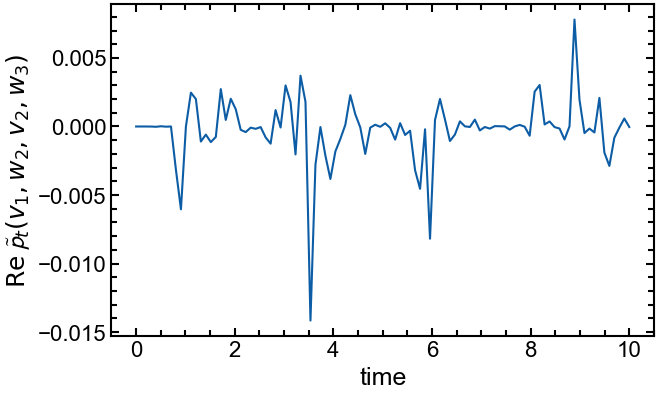

In [20]:
fig = plt.figure()

# Choose specific indices (i, j, k, l) to plot
i, j, k, l = 0, 0, 1, 1

# Extract the real part of the chosen element from each P_tilde in P_tilde_list
data_to_plot = [np.real(P_tilde[i, j, k, l]) for P_tilde in P_tilde_list]

# Now plot
plt.plot(tlist, data_to_plot)
plt.xlabel('time')
plt.ylabel(r'$\mathrm{Re} \: \mathcal{\tilde{p}}_{t}(v_{1},w_{2},v_{2},w_{3})$')
plt.show()

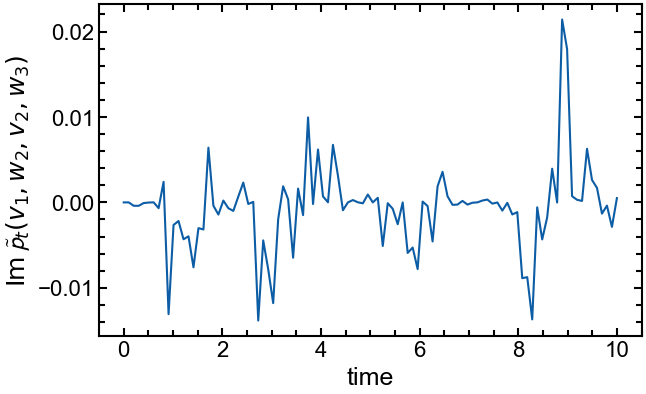

In [17]:
fig = plt.figure()

# Choose specific indices (i, j, k, l) to plot
i, j, k, l = 0, 0, 0, 0

# Extract the real part of the chosen element from each P_tilde in P_tilde_list
data_to_plot = [np.imag(P_tilde[i, j, k, l]) for P_tilde in P_tilde_list]

# Now plot
plt.plot(tlist, data_to_plot)
plt.xlabel('time')
plt.ylabel(r'$\mathrm{Im} \: \mathcal{\tilde{p}}_{t}(v_{1},w_{2},v_{2},w_{3})$')
plt.show()

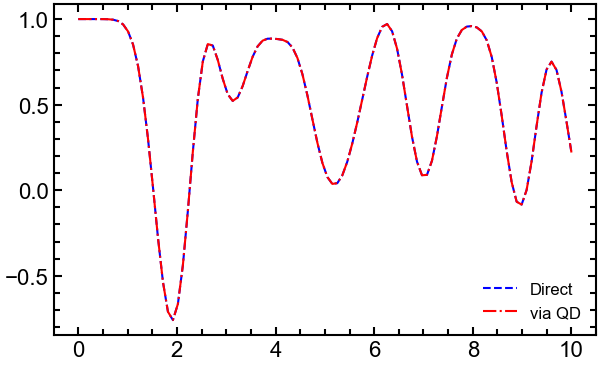

In [18]:
fig = plt.figure()

plt.plot(tlist, OTOCsList, 'b--', label='Direct')
plt.plot(tlist, OTOCsList_QD, 'r-.', label ='via QD')

plt.legend(loc='best')

plt.show()

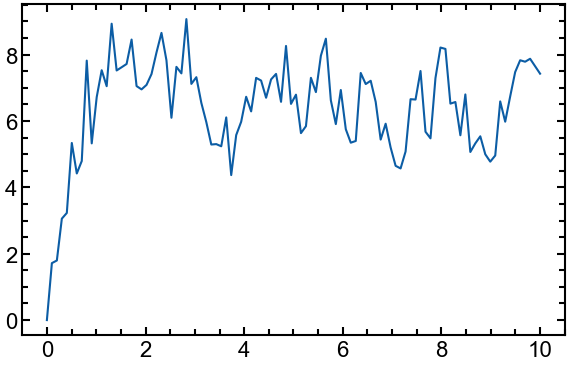

In [19]:
fig = plt.figure()

plt.plot(tlist, Total_Nonclassicality_List)

plt.show()